In [1]:
#TASK 1 - lEARNING CURVE

In [1]:
import qml
import os
from qml.kernels import gaussian_kernel
import numpy as np
from qml.math import cho_solve
import random
import matplotlib.pyplot as plt

In [2]:
# load geometries
compounds = [qml.Compound(xyz="geometries/"+f) for f in sorted(os.listdir("geometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="row-norm")
X = np.array([mol.representation for mol in compounds])

# load energies
energy_pbe0 = np.loadtxt("E_sto-3g.txt")
                                                                          
# Split data
n_train = 8000
n_test = len(X) - n_train
X_training = X[:n_train]
Y_training = energy_pbe0[:n_train]
X_test = X[-n_test:]
Y_test = energy_pbe0[-n_test:]

n_train1 = 500
X_training1 = X[:n_train1]
Y_training1 = energy_pbe0[:n_train1]

In [3]:
# calculate kernel matrix
sigma = 4000.0
K = gaussian_kernel(X_training, X_training, sigma)
K[np.diag_indices_from(K)] += 1e-8

alpha = cho_solve(K, Y_training)

In [10]:
# Calculate a kernel matrix between test and training data, using the same sigma
Ks = gaussian_kernel(X_test, X_training, sigma)

# Make the predictions
Y_predicted = np.dot(Ks, alpha)

# Calculate mean-absolute-error (MAE):
print(np.mean(np.abs(Y_predicted - Y_test)))

0.011652848301600767


In [11]:
class KernelRidgeRegression:
    __doc__ = '\n kernel rigde regression \n'
    
    def __init__(self, kernel=gaussian_kernel, kernel_parameter=4000, regularization=1e-8):
        self.kernel = kernel
        self.kernel_parameter = kernel_parameter
        self.regularization = regularization
        
        self.X_train = None
        self.alpha = None   
        
    def fit(self, X, Y):
            self.X_train = X
            sigma = self.kernel_parameter
            K = self.kernel(X, X, sigma)
            K[np.diag_indices_from(K)] += self.regularization
            self.alpha = cho_solve(K, Y)
            return self.alpha
        
    def predict(self, X):
            sigma = self.kernel_parameter
            K = self.kernel(X, self.X_train, sigma)
            Y_pred = np.dot(K, self.alpha)
            
            return Y_pred

In [12]:
model = KernelRidgeRegression()

In [13]:
n_samples = [2**i for i in range(1, 10)]

In [14]:
maes = []

for n in n_samples:
    model.fit(X_training[:n], Y_training[:n])
    Y_pred = model.predict(X_test)
    mae = np.mean(np.abs(Y_pred - Y_test))
    maes.append(mae)

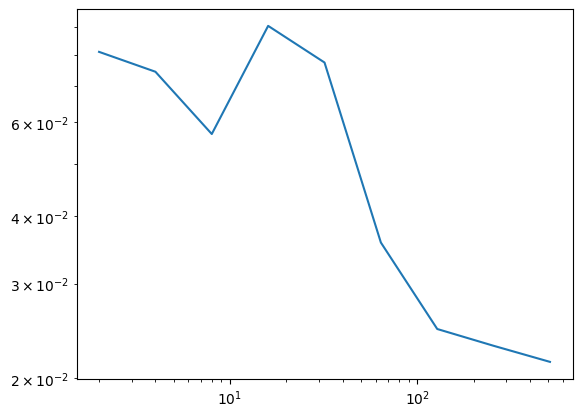

In [15]:
#Learning Curve
plt.loglog(n_samples, maes)

In [ ]:
# TASK 2 - AVERAGE LEARNING CURVE

In [16]:
maes_shufflings = []

for i in range(5):
    # rng = random number generator
    rng = np.random.default_rng(i)
    shuffle_inds = rng.permutation(len(X_training)) # testing data should be same

    X_training = X_training[shuffle_inds]
    Y_training = Y_training[shuffle_inds]
  
    maes = []
    for n in n_samples:
        model.fit(X_training[:n], Y_training[:n])
        Y_pred = model.predict(X_test)
        mae = np.mean(np.abs(Y_pred - Y_test))
        maes.append(mae)
    maes_shufflings.append(maes)

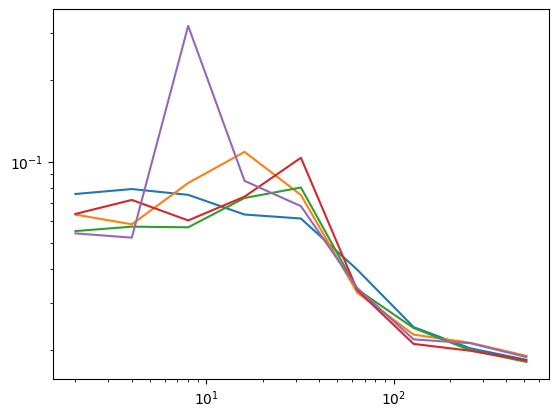

In [17]:
#Learning Curve after shuffling
for i in range(5):
    plt.loglog(n_samples, maes_shufflings[i])

In [18]:
maes_average = []

for i in range(len(n_samples)):
    
    maes_average_indexes = 0 
    for j in range(5):
        
        maes_average_indexes += maes_shufflings[j][i]
    maes_average_indexes = maes_average_indexes/5
    maes_average.append(maes_average_indexes)

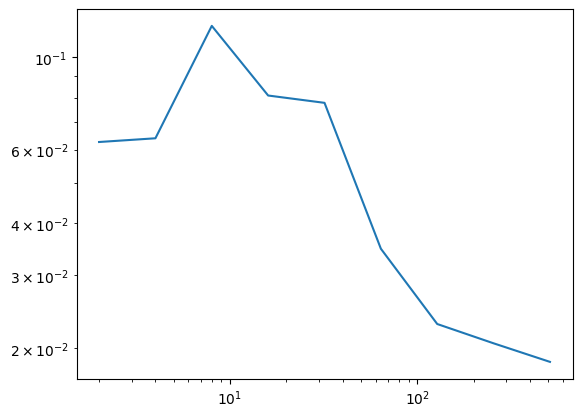

In [19]:
#Average Learning Curve
plt.loglog(n_samples, maes_average)

In [ ]:
# HYPERPARAMETER OPTIMIZATION

In [20]:
# Hyperparameter Optimization (train = 8000 and test = (total - 8000) )

sigmas = []
maes_opt = []

sigma_opt=0
for i in range(40):
    
    sigma_opt+=100
    sigmas.append(sigma_opt)
    
    # calculate kernel matrix
    sigma = sigma_opt
    K = gaussian_kernel(X_training, X_training, sigma)
    K[np.diag_indices_from(K)] += 1e-8

    alpha = cho_solve(K, Y_training)
    
    # Calculate a kernel matrix between test and training data, using the same sigma
    Ks = gaussian_kernel(X_test, X_training, sigma)

    # Make the predictions
    Y_predicted = np.dot(Ks, alpha)

    # Calculate mean-absolute-error (MAE):
    maes_opt.append(np.mean(np.abs(Y_predicted - Y_test)))

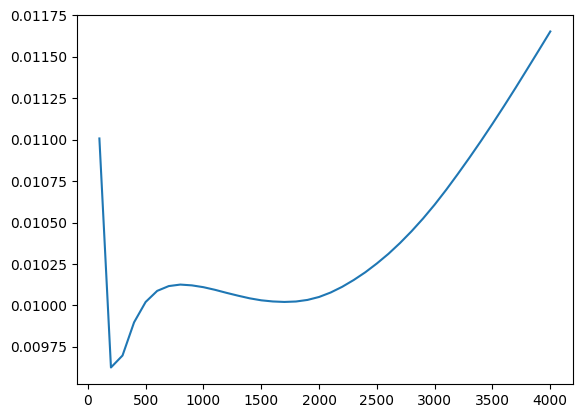

In [21]:
plt.plot(sigmas, maes_opt)

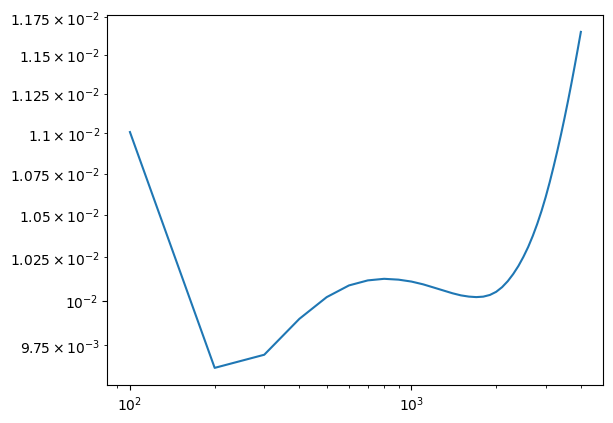

In [22]:
plt.loglog(sigmas, maes_opt)

In [25]:
# Hyperparameter optimization with less training data

sigmas1 = []
maes_opt1 = []

sigma_opt=0
for i in range(40):
    
    sigma_opt+=100
    sigmas1.append(sigma_opt)
    
    # calculate kernel matrix
    sigma = sigma_opt
    K = gaussian_kernel(X_training1, X_training1, sigma)
    K[np.diag_indices_from(K)] += 1e-8

    alpha = cho_solve(K, Y_training1)
    
    # Calculate a kernel matrix between test and training data, using the same sigma
    Ks = gaussian_kernel(X_test, X_training1, sigma)

    # Make the predictions
    Y_predicted = np.dot(Ks, alpha)

    # Calculate mean-absolute-error (MAE):
    maes_opt1.append(np.mean(np.abs(Y_predicted - Y_test)))


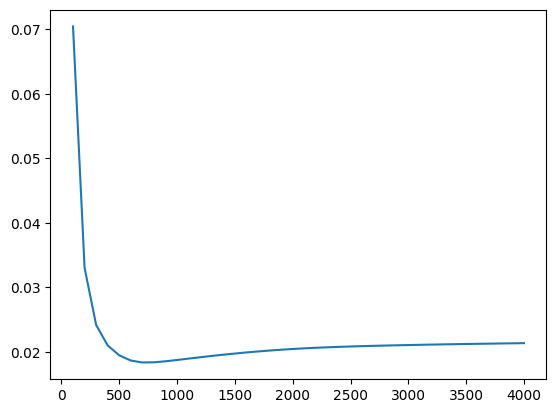

In [27]:
plt.plot(sigmas1, maes_opt1)

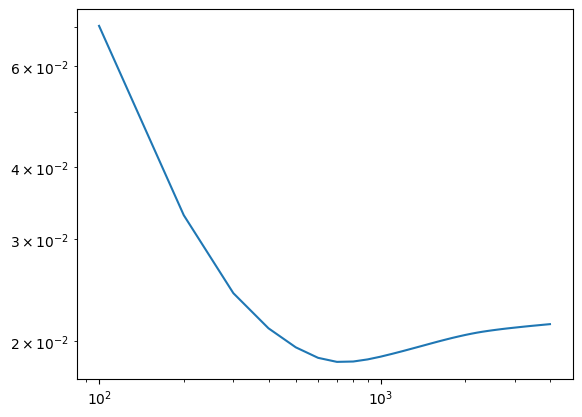

In [28]:
plt.loglog(sigmas1, maes_opt1)

In [29]:
print(sigmas1)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000]


In [30]:
print(maes_opt1)

[0.07041716643735124, 0.033041848182967654, 0.024200134112083712, 0.021028985997731207, 0.019490235998083964, 0.01868922875479427, 0.018389507806885374, 0.01841587958548906, 0.01857204098255247, 0.018774970950217577, 0.01899065728685846, 0.019200090142063593, 0.0194032589854755, 0.01959377899062744, 0.019774801471988727, 0.01994392362791608, 0.020097131750476952, 0.02023828425622997, 0.020363517147821426, 0.02047771743985749, 0.020577940220715768, 0.020666305543571555, 0.02074195141055218, 0.02080662865515445, 0.020865147108871104, 0.02091775236004772, 0.020966391576319778, 0.021010838986827613, 0.0210509070262195, 0.021088376414308434, 0.021124519341348836, 0.021159022275863727, 0.02119210768912766, 0.021222917737561565, 0.021251510166908558, 0.02127878828159835, 0.021305870219912794, 0.021332422321961232, 0.02135774824809601, 0.021382446771564846]


In [31]:
# Sigma with least MAE is 700
# Learning Curve with new sigma

import qml
import os
from qml.kernels import gaussian_kernel
import numpy as np
from qml.math import cho_solve
import random
import matplotlib.pyplot as plt

In [32]:
# load geometries
compounds = [qml.Compound(xyz="geometries/"+f) for f in sorted(os.listdir("geometries/"))]
for mol in compounds:
    mol.generate_coulomb_matrix(size=12, sorting="row-norm")
X = np.array([mol.representation for mol in compounds])

# load energies
energy_pbe0 = np.loadtxt("E_sto-3g.txt")
energy_pbe0 = data['E']
                                                                          
# Split data
n_train = 8000
n_test = len(X) - n_train
X_training = X[:n_train]
Y_training = energy_pbe0[:n_train]
X_test = X[-n_test:]
Y_test = energy_pbe0[-n_test:]

n_train1 = 500
X_training1 = X[:n_train1]
Y_training1 = energy_pbe0[:n_train1]

In [42]:
compounds[0].energy

nan

In [33]:
# calculate kernel matrix
newsigma = 700.0
K = gaussian_kernel(X_training, X_training, newsigma)
K[np.diag_indices_from(K)] += 1e-8

alpha = cho_solve(K, Y_training)

In [34]:
# Calculate a kernel matrix between test and training data, using the same sigma
Ks = gaussian_kernel(X_test, X_training, newsigma)

# Make the predictions
Y_predicted = np.dot(Ks, alpha)

# Calculate mean-absolute-error (MAE):
print(np.mean(np.abs(Y_predicted - Y_test)))

0.010116788830188895


In [35]:
class KernelRidgeRegression:
    __doc__ = '\n kernel rigde regression \n'
    
    def __init__(self, kernel=gaussian_kernel, newkernel_parameter=700, regularization=1e-8):
        self.kernel = kernel
        self.newkernel_parameter = newkernel_parameter
        self.regularization = regularization
        
        self.X_train = None
        self.alpha = None   
        
    def fit(self, X, Y):
            self.X_train = X
            newsigma = self.newkernel_parameter
            K = self.kernel(X, X, newsigma)
            K[np.diag_indices_from(K)] += self.regularization
            self.alpha = cho_solve(K, Y)
            return self.alpha
        
    def predict(self, X):
            newsigma = self.newkernel_parameter
            K = self.kernel(X, self.X_train, newsigma)
            Y_pred = np.dot(K, self.alpha)
            
            return Y_pred

In [36]:
model = KernelRidgeRegression()

In [37]:
n_samples = [2**i for i in range(1, 10)]

In [38]:
maes = []

for n in n_samples:
    model.fit(X_training[:n], Y_training[:n])
    Y_pred = model.predict(X_test)
    mae = np.mean(np.abs(Y_pred - Y_test))
    maes.append(mae)

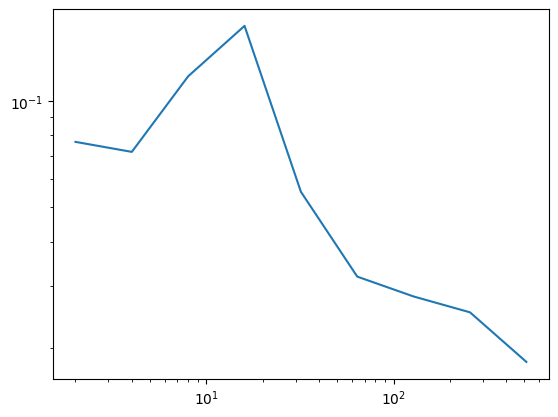

In [39]:
#Learning Curve
plt.loglog(n_samples, maes)